**NOTE:** this notebook has been modified to replace original brute force estimate by current scikit-learn brute force algorithm using `sklearn.neighbors.NearestNeighbors`

# Benchmarking Nearest Neighbor Searches in Python

*This notebook originally appeared as a*
[*blog post*](http://jakevdp.github.com/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/)
*by Jake Vanderplas on*
[*Pythonic Perambulations*](http://jakevdp.github.com/)

<!-- PELICAN_BEGIN_SUMMARY -->

I recently submitted a scikit-learn [pull request](https://github.com/scikit-learn/scikit-learn/pull/1732)
containing a brand new ball tree and kd-tree for fast nearest neighbor searches in python.
In this post I want to highlight some of the features of the new ball tree and kd-tree
code that's part of this pull request, compare it to what's available in the
``scipy.spatial.cKDTree`` implementation, and run a few benchmarks showing the
performance of these methods on various data sets.

<!-- PELICAN_END_SUMMARY -->

My first-ever open source contribution was a C++
Ball Tree code, with
a SWIG python wrapper, that I submitted to scikit-learn.
A [Ball Tree](https://en.wikipedia.org/wiki/Ball_tree)
is a data structure that can be
used for fast high-dimensional nearest-neighbor searches:
I'd written it for some work I was doing on
nonlinear dimensionality reduction of astronomical data (work
that eventually led to
[these](http://adsabs.harvard.edu/abs/2009AJ....138.1365V)
[two](http://adsabs.harvard.edu/abs/2011AJ....142..203D) papers),
and thought that it might find a good home in the scikit-learn
project, which Gael and others had just begun to bring out of
hibernation.

After a short time, it became clear that the C++ code was not performing as
well as it could be.  I spent a bit of time writing a Cython adaptation of
the Ball Tree, which is what currently resides in the
[``sklearn.neighbors``](http://scikit-learn.org/0.13/modules/neighbors.html)
module.  Though this implementation is fairly fast, it still has several
weaknesses:

- It only works with a Minkowski distance metric (of which Euclidean is a
  special case).  In general, a ball tree can be written to handle any
  true metric (i.e. one which obeys the triangle inequality).
- It implements only the single-tree approach, not the potentially faster
  dual-tree approach in which a ball tree is constructed for both the training
  and query sets.
- It implements only nearest-neighbors queries, and not any of the other
  tasks that a ball tree can help optimize: e.g. kernel density estimation,
  N-point correlation function calculations, and other so-called
  [Generalized N-body Problems](http://www.fast-lab.org/nbodyproblems.html).

I had started running into these limits when creating astronomical data
analysis examples for [astroML](http://www.astroML.org),
the Python library for Astronomy and Machine Learning Python
that I released last fall.  I'd been thinking about it for a while, and
finally decided it was time to invest the effort into updating and
enhancing the Ball Tree.  It took me longer than I planned (in fact, some of my
[first posts](http://jakevdp.github.io/blog/2012/08/08/memoryview-benchmarks/)
on this blog last August came out of the benchmarking experiments aimed at
this task), but just a couple weeks ago I finally got things working and submitted
a [pull request](https://github.com/scikit-learn/scikit-learn/pull/1732)
to scikit-learn with the new code.


## Features of the New Ball Tree and KD Tree

The new code is actually more than simply a new ball tree:
it's written as a generic *N* dimensional binary search
tree, with specific methods added to implement a ball tree and a kd-tree on top of
the same core functionality.  The new trees have a lot of very interesting and
powerful features:

- The ball tree works with any of the following distance metrics, which match
  those found in the module ``scipy.spatial.distance``:

    ``['euclidean', 'minkowski', 'manhattan', 'chebyshev',
     'seuclidean', 'mahalanobis', 'wminkowski', 'hamming',
     'canberra', 'braycurtis', 'matching', 'jaccard',
     'dice', 'kulsinski', 'rogerstanimoto', 'russellrao',
     'sokalmichener', 'sokalsneath', 'haversine']``
  
  Alternatively, the user can specify a callable Python function to act as the
  distance metric.  While this will be quite a bit slower than using one of the
  optimized metrics above, it adds nice flexibility.

- The kd-tree works with only the first four of the above metrics.  This
  limitation is primarily because the distance bounds are less efficiently
  calculated for metrics which are not axis-aligned.

- Both the ball tree and kd-tree implement k-neighbor and bounded neighbor searches, and
  can use either a single tree or dual tree approach, with either a breadth-first or depth-first
  tree traversal.  Naive nearest neighbor searches scale as $\mathcal{O}[N^2]$;
  the tree-based methods here scale as $\mathcal{O}[N \log N]$.

- Both the ball tree and kd-tree have their memory pre-allocated entirely by ``numpy``:
  this not only leads to code that's easier to debug and maintain (no memory errors!),
  but means that either data structure can be serialized using Python's ``pickle`` module.
  This is a very important feature in some contexts, most notably when estimators are being
  sent between multiple machines in a parallel computing framework.

- Both the ball tree and kd-tree implement fast kernel density estimation (KDE), which can be
  used within any of the valid distance metrics.  The supported kernels are

    ``['gaussian', 'tophat', 'epanechnikov',
     'exponential', 'linear', 'cosine']``

  the combination of these kernel options with the distance metric options above leads to
  an extremely large number of effective kernel forms.  Naive KDE scales as $\mathcal{O}[N^2]$;
  the tree-based methods here scale as $\mathcal{O}[N \log N]$.

- Both the ball tree and kd-tree implement fast 2-point correlation functions.  A correlation
  function is a statistical measure of the distribution of data (related to the Fourier power spectrum
  of the density distribution).  Naive 2-point correlation calculations scale as $\mathcal{O}[N^2]$;
  the tree-based methods here scale as $\mathcal{O}[N \log N]$.
  

## Comparison with cKDTree

As mentioned above, there is another nearest neighbor tree available in
the SciPy: ``scipy.spatial.cKDTree``.  There are a number of things which
distinguish the ``cKDTree`` from the new kd-tree described here:

- like the new kd-tree, ``cKDTree`` implements only the first four of the
  metrics listed above.

- Unlike the new ball tree and kd-tree, ``cKDTree`` uses explicit dynamic
  memory allocation at the construction phase.  This means that the trained
  tree object cannot be pickled, and must be re-constructed in place of
  being serialized.

- Because of the flexibility gained through the use of dynamic node allocation,
  ``cKDTree`` can implement a more sophisticated building methods: it uses the
  "sliding midpoint rule" to ensure that nodes do not become too long and thin.
  One side-effect of this, however, is that for certain distributions of points,
  you can end up with a large proliferation of the number of nodes, which may
  lead to a huge memory footprint (even memory errors in some cases) and
  potentially inefficient searches.

- The ``cKDTree`` builds its nodes covering the entire $N$-dimensional data space.
  this leads to relatively efficient build times because node bounds do not
  need to be recomputed at each level.  However, the resulting tree is not as
  compact as it could be, which potentially leads to slower query times.  The
  new ball tree and kd tree code shrinks nodes to only cover the part of the volume
  which contains points.

With these distinctions, I thought it would be interesting to do some benchmarks and
get a detailed comparison of the performance of the three trees.
Note that the ``cKDTree`` has just recently been re-written and extended, and is
much faster than its previous incarnation.  For that reason, I've run these benchmarks
with the current bleeding-edge scipy.

## Preparing the Benchmarks

But enough words.  Here we'll create some scripts to run these benchmarks.
There are several variables that will affect the computation time for a
neighbors query:

- **The number of points** $N$: for a brute-force search, the query will
  scale as $\mathcal{O}[N^2]$ .  Tree methods usually bring this down to
  $\mathcal{O}[N \log N]$ .
- **The dimension of the data**, $D$ : both brute-force and tree-based methods
  will scale approximately as $\mathcal{O}[D]$ .  For high dimensions, however,
  the [curse of dimensionality](http://en.wikipedia.org/wiki/Curse_of_dimensionality)
  can make this scaling much worse.
- **The desired number of neighbors**, $k$ : $k$ does not affect build time,
  but affects query time in a way that is difficult to quantify
- **The tree leaf size**, ``leaf_size``: The leaf size of a tree roughly specifies
  the number of points at which the tree switches to brute-force, and encodes the
  tradeoff between the cost of accessing a node, and the cost of computing the
  distance function.
- **The structure of the data**: though data structure and distribution do not
  affect brute-force queries, they can have a large effect on the query times of
  tree-based methods.
- **Single/Dual tree query**:  A single-tree query searches for neighbors of one
  point at a time.  A dual tree query builds a tree on both sets of points, and
  traverses both trees at the same time.  This can lead to significant speedups
  in some cases.
- **Breadth-first vs Depth-first search**: This determines how the nodes are
  traversed.  In practice, it seems not to make a significant difference,
  so it won't be explored here.
- **The chosen metric**: some metrics are slower to compute than others.
  The metric may also affect the structure of the data, the geometry of the tree,
  and thus the query and build times.

In reality, query times depend on all seven of these variables in a fairly complicated
way.  For that reason, I'm going to show several rounds of benchmarks where these
variables are modified while holding the others constant.  We'll do all our tests here
with the most common Euclidean distance metric, though others could be substituted
if desired.

We'll start by doing some imports to get our IPython notebook ready for the benchmarks.
Note that at present, you'll have to install scikit-learn off
[my development branch](https://github.com/jakevdp/scikit-learn/tree/new_ball_tree)
for this to work.  In the future, the new KDTree and BallTree will be part of a
scikit-learn release.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

# Modified
from sklearn.neighbors import NearestNeighbors

### Data Sets

For spatial tree benchmarks, it's important to use various realistic data sets.
In practice, data rarely looks like a uniform distribution, so running benchmarks
on such a distribution will not lead to accurate expectations of the algorithm
performance.

For this reason, we'll test three datasets side-by-side: a uniform distribution
of points, a set of pixel values from images of hand-written digits, and a set of
flux observations from astronomical spectra.

In [3]:
# Uniform random distribution
uniform_N = np.random.random((10000, 4))
uniform_D = np.random.random((1797, 128))

In [4]:
# Digits distribution
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.images.shape)

(1797, 8, 8)


In [5]:
# We need more than 1797 digits, so let's stack the central
# regions of the images to inflate the dataset.
digits_N = np.vstack([digits.images[:, 2:4, 2:4],
                      digits.images[:, 2:4, 4:6],
                      digits.images[:, 4:6, 2:4],
                      digits.images[:, 4:6, 4:6],
                      digits.images[:, 4:6, 5:7],
                      digits.images[:, 5:7, 4:6]])
digits_N = digits_N.reshape((-1, 4))[:10000]

# For the dimensionality test, we need up to 128 dimesnions, so
# we'll combine some of the images.
digits_D = np.hstack((digits.data,
                      np.vstack((digits.data[:1000], digits.data[1000:]))))
# The edge pixels are all basically zero.  For the dimensionality tests
# to be reasonable, we want the low-dimension case to probe interir pixels
digits_D = np.hstack([digits_D[:, 28:], digits_D[:, :28]])

In [6]:
# The spectra can be downloaded with astroML: see http://www.astroML.org
from astroML.datasets import fetch_sdss_corrected_spectra
spectra = fetch_sdss_corrected_spectra()['spectra']
spectra.shape

(4000, 1000)

In [7]:
# Take sections of spectra and stack them to reach N=10000 samples
spectra_N = np.vstack([spectra[:, 500:504],
                       spectra[:, 504:508],
                       spectra[:2000, 508:512]])
# Take a central region of the spectra for the dimensionality study
spectra_D = spectra[:1797, 400:528]

In [8]:
print(uniform_N.shape, uniform_D.shape)
print(digits_N.shape, digits_D.shape)
print(spectra_N.shape, spectra_D.shape)

(10000, 4) (1797, 128)
(10000, 4) (1797, 128)
(10000, 4) (1797, 128)


We now have three datasets with similar sizes.  Just for the sake of
visualization,  let's visualize two dimensions from each as a
scatter-plot:

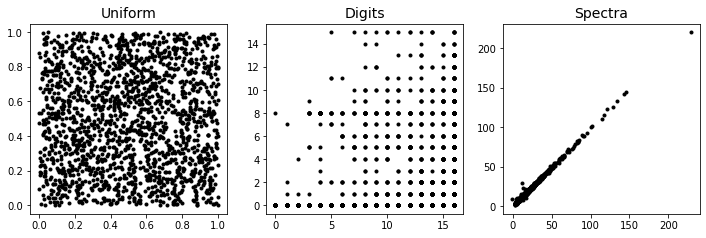

In [9]:
titles = ['Uniform', 'Digits', 'Spectra']
datasets_D = [uniform_D, digits_D, spectra_D]
datasets_N = [uniform_N, digits_N, spectra_N]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

for axi, title, dataset in zip(ax, titles, datasets_D):
    axi.plot(dataset[:, 1], dataset[:, 2], '.k')
    axi.set_title(title, size=14)

We can see how different the structure is between these three sets.  The uniform data
is randomly and densely distributed throughout the space.  The digits data actually
comprise discrete values between 0 and 16, and more-or-less fill certain regions of the
parameter space.  The spectra display strongly-correlated values, such that they
occupy a very small fraction of the total parameter volume.

### Benchmarking Scripts

Now we'll create some scripts that will help us to run the benchmarks.
Don't worry about these details for now -- you can simply scroll down past
these and get to the plots.

In [10]:
from time import time

def average_time(executable, *args, **kwargs):
    """Compute the average time over N runs"""
    N = 5
    t = 0
    for i in range(N):
        t0 = time()
        res = executable(*args, **kwargs)
        t1 = time()
        t += (t1 - t0)
    return res, t * 1. / N

In [11]:
TREE_DICT = dict(cKDTree=cKDTree, KDTree=KDTree, BallTree=BallTree)
colors = dict(cKDTree='black', KDTree='red', BallTree='blue', brute='gray', gaussian_kde='black')

def bench_knn_query(tree_name, X, N, D, leaf_size, k,
                    build_args=None, query_args=None):
    """Run benchmarks for the k-nearest neighbors query"""
    Tree = TREE_DICT[tree_name]
    
    if build_args is None:
        build_args = {}
        
    if query_args is None:
        query_args = {}
        
    NDLk = np.broadcast(N, D, leaf_size, k)
        
    t_build = np.zeros(NDLk.size)
    t_query = np.zeros(NDLk.size)
    
    for i, (N, D, leaf_size, k) in enumerate(NDLk):
        XND = X[:N, :D]
        
        if tree_name == 'cKDTree':
            build_args['leafsize'] = leaf_size
        else:
            build_args['leaf_size'] = leaf_size
        
        tree, t_build[i] = average_time(Tree, XND, **build_args)
        res, t_query[i] = average_time(tree.query, XND, k, **query_args)
        
    return t_build, t_query

In [12]:
def plot_scaling(data, estimate_brute=False, suptitle='', **kwargs):
    """Plot the scaling comparisons for different tree types"""
    # Find the iterable key
    iterables = [key for (key, val) in kwargs.items() if hasattr(val, '__len__')]
    if len(iterables) != 1:
        raise ValueError("A single iterable argument must be specified")
    x_key = iterables[0]
    x = kwargs[x_key]
    
    # Set some defaults
    if 'N' not in kwargs:
        kwargs['N'] = data.shape[0]
    if 'D' not in kwargs:
        kwargs['D'] = data.shape[1]
    if 'leaf_size' not in kwargs:
        kwargs['leaf_size'] = 15
    if 'k' not in kwargs:
        kwargs['k'] = 5
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4),
                           subplot_kw=dict(yscale='log', xscale='log'))
        
    for tree_name in ['cKDTree', 'KDTree', 'BallTree']:
        t_build, t_query = bench_knn_query(tree_name, data, **kwargs)
        ax[0].plot(x, t_build, color=colors[tree_name], label=tree_name)
        ax[1].plot(x, t_query, color=colors[tree_name], label=tree_name)
        
        if tree_name != 'cKDTree':
            t_build, t_query = bench_knn_query(tree_name, data,
                                               query_args=dict(breadth_first=True, dualtree=True),
                                               **kwargs)
            ax[0].plot(x, t_build, color=colors[tree_name], linestyle='--')
            ax[1].plot(x, t_query, color=colors[tree_name], linestyle='--')
            
    if estimate_brute:
        N = kwargs['N']
        D = kwargs['D']
        leaf_size = kwargs['leaf_size']
        k = kwargs['k']
        query_args = {'return_distance': False}
        
        NDLk = np.broadcast(N, D, leaf_size, k)
        t_query = np.zeros(NDLk.size)
        
        for i, (N, D, leaf_size, k) in enumerate(NDLk):
            XND = data[:N, :D]
            
            model = NearestNeighbors(k, algorithm='brute', n_jobs=1)
            model.fit(XND)
            res, t_query[i] = average_time(model.kneighbors, XND, **query_args)
        
        ax[1].plot(x, t_query, color=colors['brute'], label='brute force')
        
#         Nmin = np.min(kwargs['N'])
#         Dmin = np.min(kwargs['D'])
#         kmin = np.min(kwargs['k'])
        
#         # get a baseline brute force time by setting the leaf size large,
#         # ensuring a brute force calculation over the data
#         _, t0 = bench_knn_query('KDTree', data, N=Nmin, D=Dmin, leaf_size=2 * Nmin, k=kmin)
        
#         # use the theoretical scaling: O[N^2 D]
#         if x_key == 'N':
#             exponent = 2
#         elif x_key == 'D':
#             exponent = 1
#         else:
#             exponent = 0
            
#         t_brute = t0 * (np.array(x, dtype=float) / np.min(x)) ** exponent
#         ax[1].plot(x, t_brute, color=colors['brute'], label='brute force (est.)')
            
    for axi in ax:
        axi.grid(True)
        axi.set_xlabel(x_key)
        axi.set_ylabel('time (s)')
        axi.legend(loc='upper left')
        axi.set_xlim(np.min(x), np.max(x))
        
    info_str = ', '.join([key + '={' + key + '}' for key in ['N', 'D', 'k'] if key != x_key])
    ax[0].set_title('Tree Build Time ({0})'.format(info_str.format(**kwargs)))
    ax[1].set_title('Tree Query Time ({0})'.format(info_str.format(**kwargs)))
    
    if suptitle:
        fig.suptitle(suptitle, size=16)
    
    return fig, ax

## Benchmark Plots

Now that all the code is in place, we can run the benchmarks.
For all the plots, we'll show the build time and query time side-by-side.  Note the scales
on the graphs below: overall, the build times are usually a factor of 10-100
faster than the query times, so the differences in build times are rarely
worth worrying about.

A note about legends: we'll show **single-tree approaches as a solid line**, and we'll show
**dual-tree approaches as dashed lines**.
In addition, where it's relevant, we'll estimate the brute force scaling for ease of comparison.

### Scaling with Leaf Size

We will start by exploring the scaling with the ``leaf_size`` parameter: recall that the
leaf size controls the minimum number of points in a given node, and effectively
adjusts the tradeoff between the cost of node traversal and the cost of a brute-force
distance estimate.

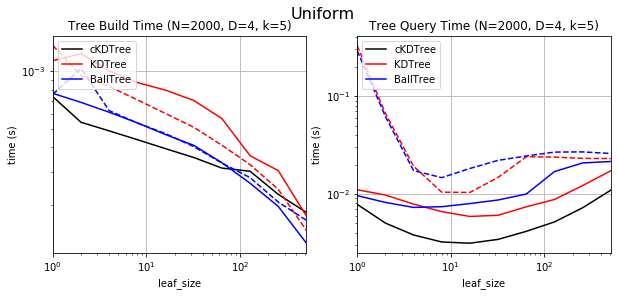

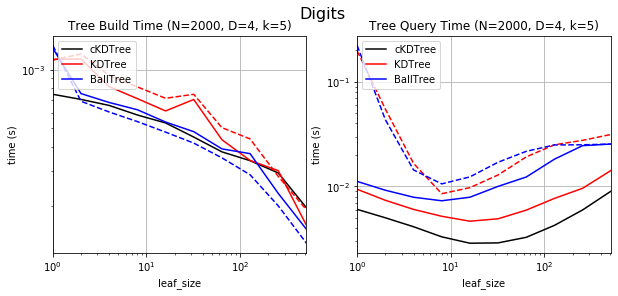

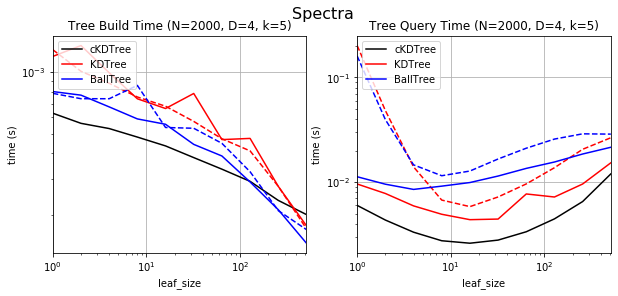

In [13]:
leaf_size = 2 ** np.arange(10)
for title, dataset in zip(titles, datasets_N):
    fig, ax = plot_scaling(dataset, N=2000, leaf_size=leaf_size, suptitle=title)

Note that with larger
leaf size, the build time decreases: this is because fewer nodes need to be built.
For the query times, we see a distinct minimum.  For very small leaf sizes,
the query slows down because the algorithm must access many nodes to complete the query.
For very large leaf sizes, the query slows down because there are too many pairwise distance
computations.  If we were to use a less efficient metric function, the balance between these
would change and a larger leaf size would be warranted.
This benchmark motivates our setting the leaf size to 15 for the remaining tests.

### Scaling with Number of Neighbors

Here we'll plot the scaling with the number of neighbors $k$.  This should not effect
the build time, because $k$ does not enter there.  It will, however, affect the
query time:

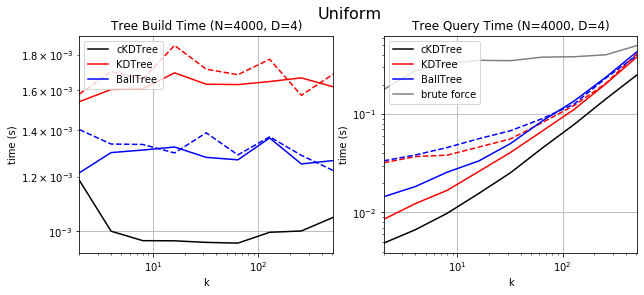

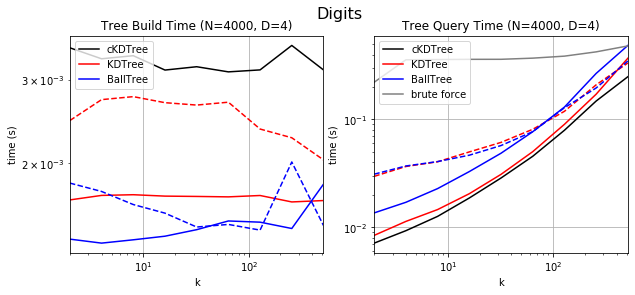

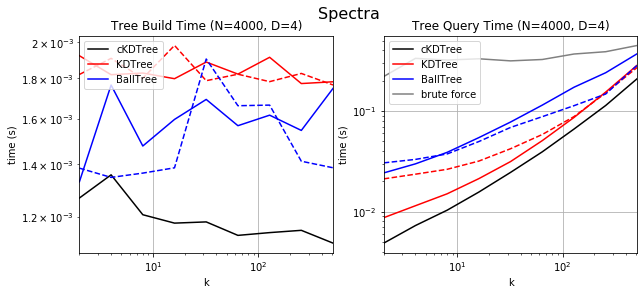

In [14]:
k = 2 ** np.arange(1, 10)
for title, dataset in zip(titles, datasets_N):
    fig, ax = plot_scaling(dataset, N=4000, k=k, suptitle=title,
                           estimate_brute=True)

Naively you might expect
linear scaling with $k$, but for large $k$ that is not the case.  Because a
priority queue of the nearest neighbors must be maintained, the scaling is
super-linear for large $k$.

We also see that brute force has no dependence on $k$ (all distances must be computed in
any case). This means that if $k$ is very large, a brute force approach will win out
(though the exact value for which this is true depends on $N$, $D$, the structure of
the data, and all the other factors mentioned above).

Note that although the cKDTree build time is a factor of ~3 faster than the
others, the absolute time difference is less than two milliseconds:
a difference which is orders of magnitude smaller than the query time.
This is due to the shortcut mentioned above: the ``cKDTree`` doesn't take the time
to shrink the bounds of each node.

### Scaling with the Number of Points

This is where things get interesting: the scaling with the number of points $N$ :

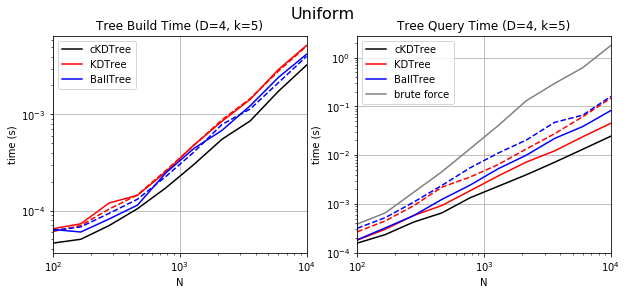

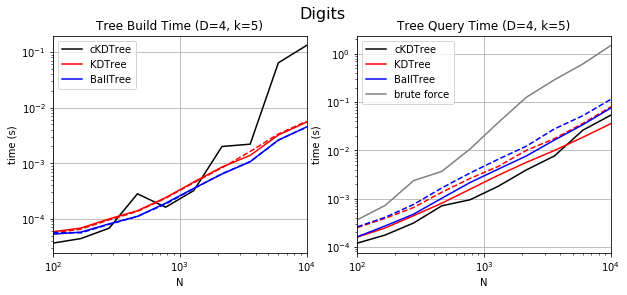

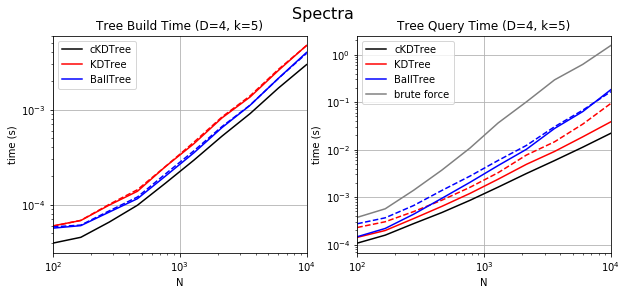

In [15]:
N = (10 ** np.linspace(2, 4, 10)).astype(int)
for title, dataset in zip(titles, datasets_N):
    plot_scaling(dataset, N=N, estimate_brute=True, suptitle=title)

We have set *d* = 4 and *k* = 5 in each case for ease of comparison.
Examining the graphs, we see some common traits:
all the tree algorithms seem to be scaling as approximately $\mathcal{O}[N\log N]$,
and both kd-trees are beating the ball tree.  Somewhat surprisingly,
the dual tree approaches are slower than the single-tree approaches.
For 10,000 points, the speedup over brute force is around a factor of 50, and
this speedup will get larger as $N$ further increases.

Additionally, the comparison of datasets is interesting.  Even for this low dimensionality,
the tree methods tend to be slightly faster for structured data than for uniform data.
Surprisingly, the ``cKDTree`` performance gets *worse* for highly structured data.
I believe this is due to the use of the sliding midpoint rule: it works well for evenly
distributed data, but for highly structured data can lead to situations where there
are many very sparsely-populated nodes.

### Scaling with the Dimension

As a final benchmark, we'll plot the scaling with dimension.

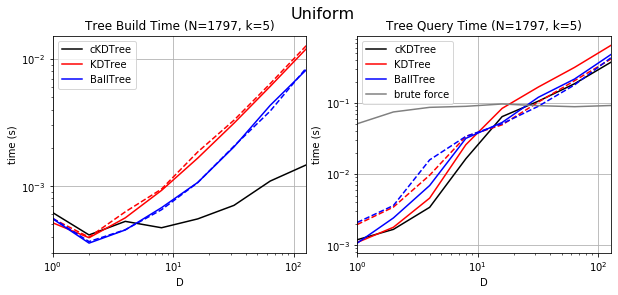

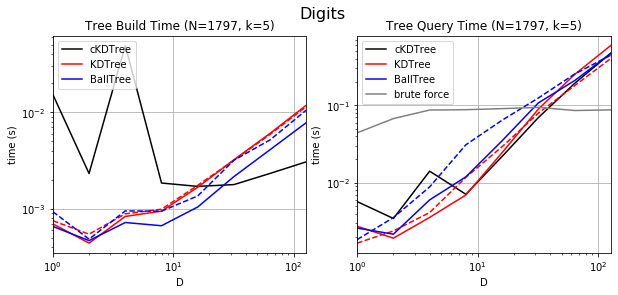

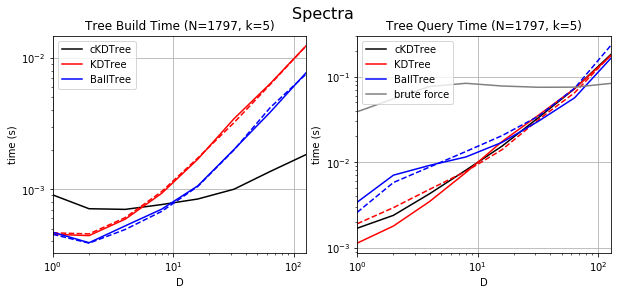

In [16]:
D = 2 ** np.arange(8)
for title, dataset in zip(titles, datasets_D):
    plot_scaling(dataset, D=D, estimate_brute=True, suptitle=title)

As we increase the dimension, we see something interesting.  For more
broadly-distributed data (uniform and digits), the dual-tree approach
begins to out-perform the single-tree approach, by as much as a factor
of 2.  In bottom-right panel, we again see a strong effect of the cKDTree's
shortcut in construction: because it builds nodes which span the entire
volume of parameter space, most of these nodes are quite empty, especially
as the dimension is increased.  This leads to queries which are quite a bit
slower for sparse data in high dimensions, and overwhelms by a factor of 100
any computational savings at construction.

## Conclusion

In a lot of ways, the plots here are their own conclusion. But in general, this
exercise convinces me that the new Ball Tree and KD Tree in scikit-learn are at the very
least equal to the scipy implementation, and in some cases much better:

- All three trees scale in the expected way with the number and dimension of the data
- All three trees beat brute force by orders of magnitude in all but the most extreme
  circumstances.
- The ``cKDTree`` seems to be less optimal for highly-structured data, which is the kind
  of data that is generally of interest.
- The ``cKDTree`` has the further disadvantage of using dynamically allocated nodes,
  which cannot be serialized.  The pre-allocation of memory
  for the new ball tree and kd tree solves this problem.

On top of this, the new ball tree and kd tree have several other advantages, including
more flexibility in traversal methods, more available metrics, and more
availale query types (e.g. KDE and 2-point correlation).

One thing that still puzzles me is the fact that the dual tree approaches don't offer
much of an improvement over single tree.  The literature on the subject would
make me expect otherwise ([FastLab](http://www.fast-lab.org/nbodyproblems.html),
for example, quotes near-linear-time queries for dual tree approaches),
so perhaps there's some efficiency I've missed.

In a later post, I plan to go into more detail and explore and benchmark
some of the new functionalities added: the kernel density estimation
and 2-point correlation function methods.  Until then,
I hope you've found this post interesting, and I hope you find this new
code useful!

This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.com/downloads/notebooks/TreeBench.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.com/downloads/notebooks/TreeBench.ipynb).